In [1]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
import re

warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

In [2]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0', low_memory=True)
train.shape

(814262, 11)

In [3]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
test.shape

(202937, 11)

In [4]:
data = pd.concat([train, test], axis=0)

In [5]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['harvesine_distance'] = [haversine(x1, y1, x2, y2) for x1, y1, x2, y2 in zip(data.x_entry, data.y_entry,
                                                                                data.x_exit, data.y_exit)]

In [7]:
data = data[data.euclidian_distance!=0]

In [8]:
# transforming time variable to timedelta format in pandas
data['minute_entry'] = data.time_entry.apply(lambda x: int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.apply(lambda x: int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [9]:
x_center = 3750901.5068 + ((3770901.5068-3750901.5068)/2)
y_center = -19268905.6133 + ((-19208905.6133+19268905.6133)/2)

In [10]:
center = {
    'x_min': 3750901.5068, 'y_min': -19268905.6133,
    'x_max': 3770901.5068, 'y_max': -19208905.6133
}

In [11]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

In [12]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

In [13]:
from shapely.geometry import LineString, Polygon

center_polygon = Polygon([(center['x_min'], center['y_min']), (center['x_min'], center['y_max']),
                          (center['x_max'], center['y_max']), (center['x_max'], center['y_min'])])


def center_permanency(row):
    
    line = LineString([(row['x_entry'], row['y_entry']), (row['x_exit'], row['y_exit'])])
    
    if not line.intersects(center_polygon):
        return 0
    
    if line.length == 0:
        # avoids divisions by 0 in 'point' trajectories
        return 0
    
    return line.intersection(center_polygon).length / line.length

data['center_permanency'] = data.apply(center_permanency, axis=1)

In [14]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')
data.head(3)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,hour_entry,hour_exit,is_inside_city_entry,is_inside_city_exit,first_quadrant_entry,third_quadrant_entry,fourth_quadrant_entry,second_quadrant_entry,center_permanency,time_delta_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,7,7,0,0,0,0,0,0,0.0,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,7,7,0,0,0,0,0,0,0.0,12.033333
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,7,8,0,0,0,0,0,0,0.0,27.833333


In [15]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,is_inside_city_exit,first_quadrant_entry,third_quadrant_entry,fourth_quadrant_entry,second_quadrant_entry,center_permanency,time_delta_blind,x_delta_blind,y_delta_blind,distance_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,0,0.0,12.033333,-6388.625577,-186127.626359,186237.235350
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,0,0.0,27.833333,-106.866711,26098.775095,26098.993888
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,0,0.0,14.416667,64.565305,551.388913,555.156205


In [16]:
data['trajectory_number'] = data.trajectory_id.apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

In [17]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [18]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

In [19]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [20]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [21]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

In [22]:
from shapely.geometry import Point, Polygon, LineString

center['left_border']  = LineString([(center['x_min'], center['y_min']), (center['x_min'], center['y_max'])])
center['right_border'] = LineString([(center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])

center['lower_border']  = LineString([(center['x_min'], center['y_min']), (center['x_max'], center['y_min'])])
center['upper_border']  = LineString([(center['x_min'], center['y_max']), (center['x_max'], center['y_max'])])


center['left_border'].distance(Point(center['x_max'], center['y_min']))

20000.0

In [23]:
def distance_left_border(x, y, border):
    if border == 'left':
        return center['left_border'].distance(Point(x, y))
    elif border == 'right':
        return center['right_border'].distance(Point(x, y))
    elif border == 'upper':
        return center['upper_border'].distance(Point(x, y))
    elif border == 'lower':
        return center['lower_border'].distance(Point(x, y))
        

data['distance_left_border'] = [distance_left_border(x, y, border='left') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_right_border'] = [distance_left_border(x, y, border='right') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_lower_border'] = [distance_left_border(x, y, border='lower') for x, y in zip(data.x_entry, data.y_entry)]
data['distance_upper_border'] = [distance_left_border(x, y, border='upper') for x, y in zip(data.x_entry, data.y_entry)]

In [96]:
def has_crossed_city(row):
    
    is_inside_city_entry = is_inside_city(row['x_entry'], row['y_entry'])
    is_inside_city_exit  = is_inside_city(row['x_exit'], row['y_exit'])
    
    line = LineString([(row['x_entry'], row['y_entry']), (row['x_exit'], row['y_exit'])])
    
    if not line.intersects(center_polygon):
        return 0
    
    if line.length == 0:
        # avoids divisions by 0 in 'point' trajectories
        return 0
    
    
    if line.intersects(center_polygon) and is_inside_city_entry == 0 and is_inside_city_exit == 1:
        return 1
    
    return 0

data['has_crossed_city'] = data.apply(has_crossed_city, axis=1)

# Sequence Data

In [176]:
window_reference = 5

grouped = data.groupby(['hash']).tail(window_reference)
grouped['sequence'] = np.ones(grouped.shape[0])
df = grouped.groupby(by=['hash','time_entry', 'trajectory_id']).sum().groupby(level=[0]).cumsum().reset_index()[['trajectory_id', 'sequence']]
df.columns = ['trajectory_id', 'trajectory_sequence']
grouped = grouped.merge(df, on='trajectory_id', how='left')

In [177]:
hash_count_trajectories = grouped.groupby(['hash']).trajectory_id.count().reset_index()
hash_count_trajectories.columns = ['hash', 'count_trajectories']

grouped = grouped.merge(hash_count_trajectories, on='hash', how='left')
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_entry,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,has_crossed_city,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-2.856258,-2.851747,25386.747582,35858.533322,25386.747582,84874.048910,0,1.0,1.0,3
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-2.850029,-2.839174,24146.972686,34984.767305,24146.972686,83601.282594,0,1.0,2.0,3
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,-2.785709,-2.779710,14234.591990,28998.252541,14234.591990,73171.112481,0,1.0,3.0,3
3,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,15:00:32,15:29:48,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,...,-2.731109,-2.745893,1813.564585,21813.564585,3382.552404,57173.487146,0,1.0,1.0,1


In [178]:
ref = window_reference
for i in range(1, window_reference):
    grouped.loc[grouped.count_trajectories==i, 'trajectory_sequence'] += ref-1
    ref -= 1
    
grouped.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,direction_entry,direction_exit,distance_left_border,distance_right_border,distance_lower_border,distance_upper_border,has_crossed_city,sequence,trajectory_sequence,count_trajectories
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-2.856258,-2.851747,25386.747582,35858.533322,25386.747582,84874.048910,0,1.0,1.0,3
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-2.850029,-2.839174,24146.972686,34984.767305,24146.972686,83601.282594,0,1.0,2.0,3
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,-2.785709,-2.779710,14234.591990,28998.252541,14234.591990,73171.112481,0,1.0,3.0,3
3,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,15:00:32,15:29:48,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,...,-2.731109,-2.745893,1813.564585,21813.564585,3382.552404,57173.487146,0,1.0,3.0,1


In [179]:
grouped = grouped.drop('sequence', axis=1)
#grouped['traje']

In [180]:
data_sequence = grouped.groupby(['hash', 'trajectory_sequence']).mean().unstack()
data_sequence.shape

(144216, 126)

In [181]:
data_sequence.columns = ['_'.join([x[0], str(int(x[1]))]) for x in data_sequence.columns.ravel()]
data_sequence.head(3)

,vmax_1,vmax_2,vmax_3,vmin_1,vmin_2,vmin_3,vmean_1,vmean_2,vmean_3,x_entry_1,...,distance_lower_border_3,distance_upper_border_1,distance_upper_border_2,distance_upper_border_3,has_crossed_city_1,has_crossed_city_2,has_crossed_city_3,count_trajectories_1,count_trajectories_2,count_trajectories_3
hash,,,,,,,,,,,,,,,,,,,,,
0000a8602cf2def930488dee7cdad104_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.744868e+06,...,14234.591990,84874.04891,83601.282594,73171.112481,0.0,0.0,0.0,3.0,3.0,3.0
0000cf177130469eeac79f67b6bcf3df_9,NaN,NaN,1.149404,NaN,NaN,1.149404,NaN,NaN,1.149404,NaN,...,3382.552404,NaN,NaN,57173.487146,NaN,NaN,0.0,NaN,NaN,1.0
0001f97b99a80f18f62e2d44e54ef33d_3,NaN,32.196255,30.167742,NaN,32.196255,30.167742,NaN,32.196255,30.167742,NaN,...,107034.585072,NaN,104772.796688,167034.585072,NaN,0.0,0.0,NaN,2.0,2.0


In [182]:
data_sequence = data_sequence.reset_index()

In [183]:
data_sequence.shape

(144216, 127)

In [184]:
data_train = data_sequence[data_sequence['hour_exit_'+str(window_reference)]==15]
data_train.shape

(100404, 127)

In [185]:
hashs_train = list(train.hash.unique())
hashs_test = list(test.hash.unique())

data_train = data_train[data_train.hash.isin(hashs_train)]
data_train.shape

(66898, 127)

In [186]:
drop_cols = ['x_exit', 'y_exit', 'euclidian_distance', 'minkowski_distance',
            'harvesine_distance', 'minute_exit', 'is_inside_city_exit', 'center_permanency',
            'distance_cc_exit', 'diff_cc_exit_entry', 'x_diff_exit', 'y_diff_exit', 'direction_exit',
            'has_crossed_city']
drop_cols = [col+'_'+str(window_reference) for col in drop_cols]
drop_cols += ['hash']

features = list(set(data_train.columns) - set(drop_cols))
target   = ['is_inside_city_exit_'+str(window_reference)]

In [187]:
from sklearn.model_selection import train_test_split


dt_train, dt_test = train_test_split(data_train, test_size=0.2, random_state=20)
dt_train.shape, dt_test.shape

((53518, 127), (13380, 127))

In [189]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

clf = LGBMClassifier(n_estimators=150, seed=20)
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.7360357484838813

In [ ]:
# Score 0.7413765697027499 | 0.89307 - n_estimators=150, max_features=0.5

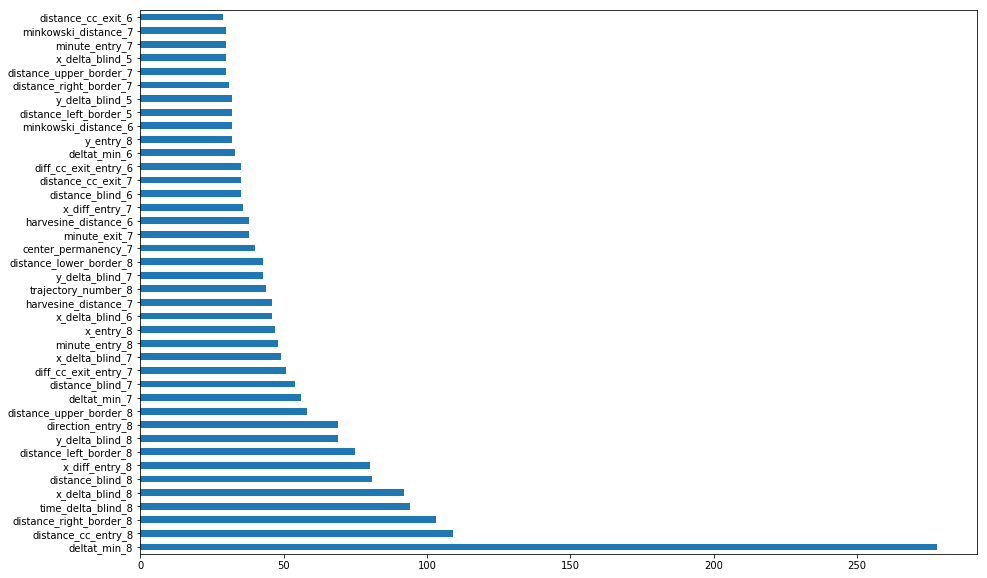

In [166]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(clf.feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(40).plot(kind='barh')

In [167]:
test = data_sequence[data_sequence.hash.isin(hashs_test)]
data_test = test[test['x_exit_'+str(window_reference)].isnull()]

In [168]:
data_test.shape

(33515, 337)

In [169]:
ids = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0', low_memory=True)
ids = ids[ids.x_exit.isnull()]

In [170]:
data_test = data_test.merge(ids[['hash', 'trajectory_id']], on='hash')

In [171]:
clf.fit(data_train[features], data_train[target])
yhat = clf.predict(data_test[features])

In [172]:
pd.Series(yhat).value_counts()

0.0    25066
1.0     8449
dtype: int64

In [173]:
data_test.head(4)

,hash,vmax_1,vmax_2,vmax_3,vmax_4,vmax_5,vmax_6,vmax_7,vmax_8,vmin_1,...,has_crossed_city_8,count_trajectories_1,count_trajectories_2,count_trajectories_3,count_trajectories_4,count_trajectories_5,count_trajectories_6,count_trajectories_7,count_trajectories_8,trajectory_id
0,00032f51796fd5437b238e3a9823d13d_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,traj_00032f51796fd5437b238e3a9823d13d_31_5
1,000479418b5561ab694a2870cc04fd43_25,NaN,NaN,NaN,NaN,NaN,17.29,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,traj_000479418b5561ab694a2870cc04fd43_25_10
2,000506a39775e5bca661ac80e3f466eb_29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,traj_000506a39775e5bca661ac80e3f466eb_29_5
3,0005401ceddaf27a9b7f0d42ef1fbe95_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4


In [174]:
submission = pd.DataFrame(list(zip(data_test['trajectory_id'], yhat)), columns=['id', 'target'])

In [175]:
submission.to_csv('../data/submission49_victor.csv', index=False)